In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torchvision.transforms import v2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.models as models

**Download CIFAR-10 and CIFAR-100 from the provided links.**

In [5]:
! wget -P /ssd_scratch/cvit/sou/ https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2024-03-28 19:58:13--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘/ssd_scratch/cvit/sou/cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M   778KB/s    in 4m 18s  

2024-03-28 20:02:33 (646 KB/s) - ‘/ssd_scratch/cvit/sou/cifar-10-python.tar.gz’ saved [170498071/170498071]



In [6]:
! wget -P /ssd_scratch/cvit/sou/ https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz

--2024-03-28 20:02:33--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘/ssd_scratch/cvit/sou/cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  7.78MB/s    in 44s     

2024-03-28 20:03:18 (3.69 MB/s) - ‘/ssd_scratch/cvit/sou/cifar-100-python.tar.gz’ saved [169001437/169001437]



In [6]:
! tar -xzvf /ssd_scratch/cvit/sou/cifar-10-python.tar.gz
! tar -xzvf /ssd_scratch/cvit/sou/cifar-100-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


**Data Exploration**

In [7]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [8]:
train_cf10 = unpickle('/ssd_scratch/cvit/sou/cifar-10-batches-py/data_batch_1')

In [9]:
train_cf10.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [10]:
len(train_cf10[b'labels'])

10000

In [11]:
type(train_cf10[b'data'])

numpy.ndarray

In [12]:
train_cf10[b'data'].shape

(10000, 3072)

In [13]:
len(train_cf10[b'filenames'])

10000

In [14]:
train_cf10[b'filenames'][100]

b'abandoned_ship_s_000574.png'

In [15]:
image_array = train_cf10[b'data'][100]
label = str(train_cf10[b'filenames'][100]).split('_')[0].replace(r"b'","")

Label is -- abandoned


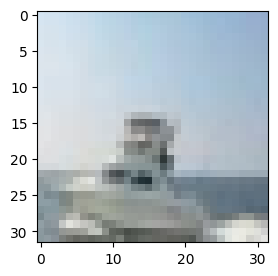

In [16]:
plt.figure(figsize=(3,3))
image_R = np.reshape(image_array[0:1024], (32,32))
image_G = np.reshape(image_array[1024:2048], (32,32))
image_B = np.reshape(image_array[2048:4096], (32,32))
image = np.dstack((image_R, image_G, image_B))
print("Label is --",label)
plt.imshow(image)
plt.show()


In [17]:
train_cf10[b'labels'][0]

6

**Building dataloader and traning**

In [25]:
class cifar(Dataset):
    def __init__(self, root_dir,train=True):
        self.root_dir = root_dir
        self.cf10 = unpickle(self.root_dir)
        if train:
            self.transforms = v2.Compose([
                v2.RandomHorizontalFlip(p=0.5),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        else :
            self.transforms = v2.Compose([
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

    def __len__(self):
        return len(train_cf10[b'labels'])

    def __getitem__(self, idx):
        image_array = self.cf10[b'data'][idx]
        image_R = np.reshape(image_array[0:1024], (32,32))
        image_G = np.reshape(image_array[1024:2048], (32,32))
        image_B = np.reshape(image_array[2048:4096], (32,32))
        image = np.dstack((image_R, image_G, image_B))

        label = self.cf10[b'labels'][idx]
        
        image_tensor = torch.FloatTensor(image)
        return image_tensor.permute(2,0,1), torch.tensor(label)        


In [26]:
cifar10_train_dataset = cifar(root_dir = '/ssd_scratch/cvit/sou/cifar-10-batches-py/data_batch_1')
cifar10_test_dataset = cifar(root_dir = '/ssd_scratch/cvit/sou/cifar-10-batches-py/test_batch', train=False)
train_dataloader_cifar10 = DataLoader(cifar10_train_dataset, batch_size=128, shuffle=True)
test_dataloader_cifar10 = DataLoader(cifar10_test_dataset, batch_size=128, shuffle=True)

In [27]:
len(train_dataloader_cifar10)

79

In [28]:
cifar10_test_dataset.__len__()

10000

In [29]:
cifar10_train_dataset.__len__()

10000

In [30]:
# Helper Functions

In [46]:
softmax = nn.Softmax(dim=1)
def calc_accuracy(pred,true):
    output = softmax(pred)
    _, predicted = torch.max(output.data, 1)
    total = true.size(0)
    correct = (predicted == true).sum().item()
    return correct/total

def evaluate(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_dataloader_cifar10:
            images, labels = data
            outputs = model(images.cuda())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.cuda()).sum().item()
            
    print('Accuracy of the MLP network on the 10000 test images: %d %%' % (
        100 * correct / total))
    

## MLP

In [32]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.relu = nn.ReLU()
        self.mlp_modules=nn.ModuleList([
        nn.Linear(3 * 32 * 32, 512),
        self.relu,
        nn.Linear(512, 256),
        self.relu,
        nn.Linear(256, 128),
        self.relu,
        nn.Linear(128, 64),
        self.relu,
        nn.Linear(64, 10)
        ])

    def forward(self, x):
        for f in self.mlp_modules:
            x = f(x)
        return x


In [33]:
device = 'cuda'

In [34]:
mlp_model = MLP()
mlp_model = mlp_model.to(device)

In [35]:
criterion = nn.CrossEntropyLoss()

In [36]:
optimizer = optim.Adam(mlp_model.parameters())

In [37]:
# Train the MLP model
epochs = 100
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    accuracy = 0.0
    running_total = 0
    for i, data in enumerate(train_dataloader_cifar10, 0):
        total_len = len(train_dataloader_cifar10) -1
        inputs, labels = data

        optimizer.zero_grad()

        logits = mlp_model(inputs.reshape(inputs.size(0),-1).cuda())
        loss = criterion(logits, labels.cuda())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_total +=1
        accuracy+=calc_accuracy(logits,labels.cuda())
        #if i % 10 == 0 or i == total_len :  # print every 2000 mini-batches
        if i == total_len :
            print(f"Epoch = {epoch+1} ----- Step = {i} ----- Loss = {running_loss/running_total} ---- Accuracy = {accuracy/running_total}")
            running_loss = 0.0
            accuracy = 0.0
            running_total = 0

print('Finished Training')



Epoch = 1 ----- Step = 78 ----- Loss = 5.27656826791884 ---- Accuracy = 0.14359177215189872
Epoch = 2 ----- Step = 78 ----- Loss = 2.0659641857388653 ---- Accuracy = 0.25375791139240506
Epoch = 3 ----- Step = 78 ----- Loss = 2.0214084235927725 ---- Accuracy = 0.2775909810126582
Epoch = 4 ----- Step = 78 ----- Loss = 1.9154013908362086 ---- Accuracy = 0.317246835443038
Epoch = 5 ----- Step = 78 ----- Loss = 1.8579165497912635 ---- Accuracy = 0.3381131329113924
Epoch = 6 ----- Step = 78 ----- Loss = 1.8112899940225142 ---- Accuracy = 0.35176028481012656
Epoch = 7 ----- Step = 78 ----- Loss = 1.7823176051996932 ---- Accuracy = 0.36204509493670883
Epoch = 8 ----- Step = 78 ----- Loss = 1.7512607302846788 ---- Accuracy = 0.3741099683544304
Epoch = 9 ----- Step = 78 ----- Loss = 1.7200835807413994 ---- Accuracy = 0.3837025316455696
Epoch = 10 ----- Step = 78 ----- Loss = 1.6873287837716597 ---- Accuracy = 0.39804193037974683
Epoch = 11 ----- Step = 78 ----- Loss = 1.6739332540125786 ---- Acc

In [38]:
# Evaluating MLP model on test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader_cifar10:
        images, labels = data
        outputs = mlp_model(images.reshape(images.size(0),-1).cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()
        
print('Accuracy of the MLP network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the MLP network on the 10000 test images: 42 %


## CNN

In [39]:
class Conv2dBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, residual=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_block = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding),
                             nn.BatchNorm2d(out_channels)
                        )
        for layer in self.conv_block:
            if isinstance(layer, nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight)
        self.act = nn.ReLU()
        self.residual = residual

    def forward(self, x):
        out = self.conv_block(x)
        if self.residual:
            out += x
        return self.act(out)


class cnn_arch(nn.Module):
    def __init__(self, in_channel = 3, num_classes = 10):
        super(cnn_arch, self).__init__()

        

        self.mini_resnet=nn.ModuleList([ 
            #32
            nn.Sequential(
                Conv2dBlock(in_channels=in_channel, out_channels=32, kernel_size=(5,5), stride=(2,2), padding=2),
                Conv2dBlock(in_channels=32, out_channels=32, kernel_size=(5,5), stride=1, padding=2,residual=True),
                nn.Dropout(0.20)
            ),
            #16
            nn.Sequential(
                Conv2dBlock(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(2,2), padding=2),
                Conv2dBlock(in_channels=64, out_channels=64, kernel_size=(5,5), stride=1, padding=2,residual=True),
                nn.Dropout(0.20)
            ),
            
            #8
            nn.Sequential(
                Conv2dBlock(in_channels=64, out_channels=128, kernel_size=(5,5), stride=(2,2), padding=2),
                Conv2dBlock(in_channels=128, out_channels=128, kernel_size=(5,5), stride=1, padding=2,residual=True),
                nn.Dropout(0.20)
            )])
            

        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128,num_classes)
        

    def forward(self, x):
        b, c, h, w = x.size()
        for f in self.mini_resnet:
            x = f(x)
        x = x.view(x.size()[0],-1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [40]:
cnn = cnn_arch()

In [41]:
x = cnn(torch.rand((16,3,32,32)))

In [42]:
x.shape

torch.Size([16, 10])

In [43]:
cnn = cnn.to(device)
optimizer = optim.Adam(cnn.parameters())

In [45]:
# Train the CNN model
epochs = 100
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    accuracy = 0.0
    running_total = 0
    for i, data in enumerate(train_dataloader_cifar10, 0):
        total_len = len(train_dataloader_cifar10) -1
        inputs, labels = data

        optimizer.zero_grad()

        logits = cnn(inputs.cuda())
        loss = criterion(logits, labels.cuda())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_total +=1
        accuracy+=calc_accuracy(logits,labels.cuda())
        #if i % 10 == 0 or i == total_len :  # print every 2000 mini-batches
        if i == total_len :
            print(f"Epoch = {epoch+1} ----- Step = {i} ----- Loss = {running_loss/running_total} ---- Accuracy = {accuracy/running_total}")
            running_loss = 0.0
            accuracy = 0.0
            running_total = 0

print('Finished Training')



Epoch = 1 ----- Step = 78 ----- Loss = 0.11288394529042364 ---- Accuracy = 0.961629746835443
Epoch = 2 ----- Step = 78 ----- Loss = 0.10799379151644586 ---- Accuracy = 0.9643987341772152
Epoch = 3 ----- Step = 78 ----- Loss = 0.09804563804329196 ---- Accuracy = 0.9658821202531646
Epoch = 4 ----- Step = 78 ----- Loss = 0.10608645832708365 ---- Accuracy = 0.9637064873417721
Epoch = 5 ----- Step = 78 ----- Loss = 0.07784696798064286 ---- Accuracy = 0.9737935126582279
Epoch = 6 ----- Step = 78 ----- Loss = 0.07672947230218333 ---- Accuracy = 0.9724090189873418
Epoch = 7 ----- Step = 78 ----- Loss = 0.06798825059321863 ---- Accuracy = 0.9769580696202531
Epoch = 8 ----- Step = 78 ----- Loss = 0.06379839511370121 ---- Accuracy = 0.9790348101265823
Epoch = 9 ----- Step = 78 ----- Loss = 0.06570701345895665 ---- Accuracy = 0.9779469936708861
Epoch = 10 ----- Step = 78 ----- Loss = 0.09688134515021421 ---- Accuracy = 0.9673655063291139
Epoch = 11 ----- Step = 78 ----- Loss = 0.08034494229226927 

In [47]:
evaluate(cnn)

Accuracy of the MLP network on the 10000 test images: 59 %


We see how MLPs achieve an accuracy of 80% on the training set whereas CNNs can go up till 99%.Although it appears that our basic CNN architecture overfits on this data still we get a test accuracy of 59% which is a major increase from the test accuracy of MLPs. This shows how well CNNs capture the both global and local features in an image. It is to be noted that both our test and train sets contain 10k images.

## VGG

In [113]:
import torchvision.models as models
vgg_model = models.vgg16(weights='DEFAULT')

In [114]:
# Freeze convolutional layers
for name,param in vgg_model.named_parameters():
    #print(name,param.shape)
    param.requires_grad = False

In [115]:
for param in vgg_model.classifier[-8:].parameters():
    param.requires_grad = True
for param in vgg_model.features[:4].parameters():
    param.requires_grad = True

In [116]:
# Here we are changing the last linear layer of our VGG

In [117]:
vgg_model.classifier[6] = nn.Linear(4096, 10)

In [118]:
for name,param in vgg_model.named_parameters():
    print(name,param.shape,param.requires_grad)

features.0.weight torch.Size([64, 3, 3, 3]) True
features.0.bias torch.Size([64]) True
features.2.weight torch.Size([64, 64, 3, 3]) True
features.2.bias torch.Size([64]) True
features.5.weight torch.Size([128, 64, 3, 3]) False
features.5.bias torch.Size([128]) False
features.7.weight torch.Size([128, 128, 3, 3]) False
features.7.bias torch.Size([128]) False
features.10.weight torch.Size([256, 128, 3, 3]) False
features.10.bias torch.Size([256]) False
features.12.weight torch.Size([256, 256, 3, 3]) False
features.12.bias torch.Size([256]) False
features.14.weight torch.Size([256, 256, 3, 3]) False
features.14.bias torch.Size([256]) False
features.17.weight torch.Size([512, 256, 3, 3]) False
features.17.bias torch.Size([512]) False
features.19.weight torch.Size([512, 512, 3, 3]) False
features.19.bias torch.Size([512]) False
features.21.weight torch.Size([512, 512, 3, 3]) False
features.21.bias torch.Size([512]) False
features.24.weight torch.Size([512, 512, 3, 3]) False
features.24.bias

In [119]:
vgg_model = vgg_model.to(device)

In [120]:
optimizer_vgg = optim.Adam(vgg_model.parameters(), lr=0.001)

In [123]:
for param in vgg_model.parameters():
    print(param.requires_grad)

True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


In [124]:
def examine_grad(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f'{name}: Gradient shape - {param.grad.shape}  --- Requires grad {param.requires_grad}')
        else:
            print(f'{name}: Gradient shape - {param.grad}  --- Requires grad {param.requires_grad}')
    

In [127]:
# Train the VGG model
epochs = 100
vgg_model.train()
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    accuracy = 0.0
    running_total = 0
    for i, data in enumerate(train_dataloader_cifar10, 0):
        total_len = len(train_dataloader_cifar10) -1
        inputs, labels = data

        optimizer_vgg.zero_grad()

        logits = vgg_model(inputs.cuda())
        
            
        loss = criterion(logits, labels.cuda())
        loss.backward()
        #examine_grad(vgg_model)
        optimizer_vgg.step()

        running_loss += loss.item()
        running_total +=1
        accuracy+=calc_accuracy(logits,labels.cuda())
        #if i % 10 == 0 or i == total_len :  # print every 2000 mini-batches
        if i == total_len :
            print(f"Epoch = {epoch+1} ----- Step = {i} ----- Loss = {running_loss/running_total} ---- Accuracy = {accuracy/running_total}")
            running_loss = 0.0
            accuracy = 0.0
            running_total = 0

print('Finished Training')

Epoch = 1 ----- Step = 78 ----- Loss = 1.4078080156181432 ---- Accuracy = 0.4730023734177215
Epoch = 2 ----- Step = 78 ----- Loss = 1.3868608172935775 ---- Accuracy = 0.4814082278481013
Epoch = 3 ----- Step = 78 ----- Loss = 1.403942904894865 ---- Accuracy = 0.47695806962025317
Epoch = 4 ----- Step = 78 ----- Loss = 1.477664749833602 ---- Accuracy = 0.4566851265822785
Epoch = 5 ----- Step = 78 ----- Loss = 1.4386595502684387 ---- Accuracy = 0.46706882911392406
Epoch = 6 ----- Step = 78 ----- Loss = 1.4412342370310915 ---- Accuracy = 0.45698180379746833
Epoch = 7 ----- Step = 78 ----- Loss = 1.3891775819319714 ---- Accuracy = 0.47794699367088606
Epoch = 8 ----- Step = 78 ----- Loss = 1.3600658857369725 ---- Accuracy = 0.489814082278481
Epoch = 9 ----- Step = 78 ----- Loss = 1.3809407225138024 ---- Accuracy = 0.48239715189873417
Epoch = 10 ----- Step = 78 ----- Loss = 1.381224304814882 ---- Accuracy = 0.4811115506329114
Epoch = 11 ----- Step = 78 ----- Loss = 1.3492151076280618 ---- Accu

In [128]:
evaluate(vgg_model)

Accuracy of the MLP network on the 10000 test images: 45 %


It seems that freezing the initial layers on VGG and transfer learning on the lower layers doesnt have much effect. However Full fine tuning yields comparable results